In [21]:
import pandas as pd
import requests
import datetime

class BinanceIngestionData:
    def __init__(self, symbol, interval, start_date, end_date):
        self.symbol = symbol
        self.interval = interval
        self.start_date = start_date
        self.end_date = end_date
        self.base_url = "https://api.binance.com/api/v3/klines"

    def fetch_data(self):
        params = {
            "symbol": self.symbol,
            "interval": self.interval,
            "startTime": int(datetime.datetime.strptime(self.start_date, "%Y-%m-%d").timestamp() * 1000),
            "endTime": int(datetime.datetime.strptime(self.end_date, "%Y-%m-%d").timestamp() * 1000),
            "limit": 1000
        }
        response = requests.get(self.base_url, params=params)
        data = response.json()

        if response.status_code != 200 or not data:
            raise Exception("Failed to fetch data. Check your symbol, interval, or date range.")

        return data

    def process_data(self, data):
        df = pd.DataFrame(data, columns=[
            "Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", 
            "Quote Asset Volume", "Number of Trades", "Taker Buy Base Asset Volume", 
            "Taker Buy Quote Asset Volume", "Ignore"
        ])

        # Convert to proper data types
        df["Open Time"] = pd.to_datetime(df["Open Time"], unit="ms")
        df.set_index("Open Time", inplace=True)
        df = df.astype({
            "Open": "float", 
            "High": "float", 
            "Low": "float", 
            "Close": "float", 
            "Volume": "float", 
            "Quote Asset Volume": "float", 
            "Number of Trades": "int", 
            "Taker Buy Base Asset Volume": "float", 
            "Taker Buy Quote Asset Volume": "float"
        })

        return df

    def save_to_csv(self, df, file_path):
        df.to_csv(file_path)
        print(f"Data saved to {file_path}")

if __name__ == "__main__":
    symbol = "BTCUSDT"
    interval = "1d"
    end_date = datetime.datetime.now().strftime("%Y-%m-%d")
    start_date = (datetime.datetime.now() - datetime.timedelta(days=730)).strftime("%Y-%m-%d")

    binance_data = BinanceIngestionData(symbol, interval, start_date, end_date)

    raw_data = binance_data.fetch_data()
    processed_data = binance_data.process_data(raw_data)
    binance_data.save_to_csv(processed_data, "BTC_2Y_Binance.csv")


Data saved to BTC_2Y_Binance.csv


In [22]:
import pandas as pd
import requests
import datetime

In [23]:
df = pd.read_csv("BTC_2Y_Binance.csv")
df.head()

,Open Time,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore
0,2023-01-14,19930.01,21258.00,19888.05,20954.92,393913.74951,1673740799999,8.183072e+09,8659545,197817.55209,4.109568e+09,0
1,2023-01-15,20952.76,21050.74,20551.01,20871.50,178542.22549,1673827199999,3.710527e+09,5194354,88310.83908,1.835437e+09,0
2,2023-01-16,20872.99,21474.05,20611.48,21185.65,293078.08262,1673913599999,6.168654e+09,6856434,145352.66942,3.059597e+09,0
3,2023-01-17,21185.65,21647.45,20841.31,21134.81,275407.74409,1673999999999,5.840586e+09,6440138,137121.64311,2.908227e+09,0
4,2023-01-18,21132.29,21650.00,20407.15,20677.47,350916.01949,1674086399999,7.399719e+09,7617173,173174.41690,3.652038e+09,0


In [24]:
df.isna().sum()

Open Time                       0
Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
Close Time                      0
Quote Asset Volume              0
Number of Trades                0
Taker Buy Base Asset Volume     0
Taker Buy Quote Asset Volume    0
Ignore                          0
dtype: int64

In [25]:
class FeatureEngineering:
    def __init__(self, df):
        self.df = df

    def add_features(self):
        
        self.df = self.df.rename(columns={"Open Time": "datetime"})
        self.df = self.df.drop(columns=["Ignore"], errors='ignore')
        self.df['High_Low_Diff'] = self.df['High'] - self.df['Low']
        self.df['Open_Close_Diff'] = self.df['Open'] - self.df['Close']
        self.df['Average_Price'] = (self.df['High'] + self.df['Low'] + self.df['Close']) / 3
        self.df['Volume_Weighted_Price'] = self.df['Quote Asset Volume'] / self.df['Volume']
        

        return self.df

In [26]:
feature_engineering = FeatureEngineering(df)
engineered_data = feature_engineering.add_features()
engineered_data.head()

,datetime,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,High_Low_Diff,Open_Close_Diff,Average_Price,Volume_Weighted_Price
0,2023-01-14,19930.01,21258.00,19888.05,20954.92,393913.74951,1673740799999,8.183072e+09,8659545,197817.55209,4.109568e+09,1369.95,-1024.91,20700.323333,20773.764757
1,2023-01-15,20952.76,21050.74,20551.01,20871.50,178542.22549,1673827199999,3.710527e+09,5194354,88310.83908,1.835437e+09,499.73,81.26,20824.416667,20782.347682
2,2023-01-16,20872.99,21474.05,20611.48,21185.65,293078.08262,1673913599999,6.168654e+09,6856434,145352.66942,3.059597e+09,862.57,-312.66,21090.393333,21047.817694
3,2023-01-17,21185.65,21647.45,20841.31,21134.81,275407.74409,1673999999999,5.840586e+09,6440138,137121.64311,2.908227e+09,806.14,50.84,21207.856667,21207.049892
4,2023-01-18,21132.29,21650.00,20407.15,20677.47,350916.01949,1674086399999,7.399719e+09,7617173,173174.41690,3.652038e+09,1242.85,454.82,20911.540000,21086.866328


In [27]:
from prophet import Prophet
from datetime import timedelta
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

class ProphetForecasting:
    def __init__(self, data, date_column, target_column):
        self.data = data
        self.date_column = date_column
        self.target_column = target_column
        self.model = Prophet(daily_seasonality=True, yearly_seasonality=True, 
                             weekly_seasonality=True, seasonality_mode='multiplicative')

    def preprocess_data(self):
        self.data = self.data.rename(columns={self.date_column: 'ds', self.target_column: 'y'})
        self.data['ds'] = pd.to_datetime(self.data['ds'])

    def train_model(self, training_period=730):
        last_date = self.data['ds'].max()
        start_date = last_date - timedelta(days=training_period)
        training_data = self.data[self.data['ds'] >= start_date]
        self.model.fit(training_data)

    def forecast(self, future_periods=180):
        future_dates = self.model.make_future_dataframe(periods=future_periods, freq='D')
        forecast = self.model.predict(future_dates)
        return forecast

    def calculate_ema(self, period, column='y'):
        self.data[f'EMA_{period}'] = self.data[column].ewm(span=period, adjust=False).mean()

    def identify_ema_signals(self, short_period=12, long_period=26):
        self.calculate_ema(short_period)
        self.calculate_ema(long_period)
        signals = []

        for i in range(1, len(self.data)):
            signal = {'time': self.data['ds'].iloc[i], 'type': None}

            if (
                self.data[f'EMA_{short_period}'].iloc[i - 1] < self.data[f'EMA_{long_period}'].iloc[i - 1] and
                self.data[f'EMA_{short_period}'].iloc[i] >= self.data[f'EMA_{long_period}'].iloc[i]
            ):
                signal['type'] = 'Bullish Crossover'
                signals.append(signal)

            elif (
                self.data[f'EMA_{short_period}'].iloc[i - 1] > self.data[f'EMA_{long_period}'].iloc[i - 1] and
                self.data[f'EMA_{short_period}'].iloc[i] <= self.data[f'EMA_{long_period}'].iloc[i]
            ):
                signal['type'] = 'Bearish Crossover'
                signals.append(signal)

        return pd.DataFrame(signals)

    def plot_forecast_with_indicators(self, forecast, short_period=12, long_period=26):
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast', line=dict(color='blue')))

        self.calculate_ema(short_period)
        self.calculate_ema(long_period)
        fig.add_trace(go.Scatter(x=self.data['ds'], y=self.data[f'EMA_{short_period}'], mode='lines', name=f'EMA {short_period}', line=dict(color='green', dash='dash')))
        fig.add_trace(go.Scatter(x=self.data['ds'], y=self.data[f'EMA_{long_period}'], mode='lines', name=f'EMA {long_period}', line=dict(color='red', dash='dash')))

        signals = self.identify_ema_signals(short_period, long_period)
        for _, signal in signals.iterrows():
            color = 'lime' if signal['type'] == 'Bullish Crossover' else 'orange'
            fig.add_trace(go.Scatter(x=[signal['time']], y=[self.data.loc[self.data['ds'] == signal['time'], 'y'].values[0]],
                                     mode='markers', marker=dict(color=color, size=10), name=signal['type']))

        fig.update_layout(
            title='Forecast with EMA Indicators',
            xaxis_title='Date',
            yaxis_title='Value',
            showlegend=True,
            template='plotly_dark'
        )
        fig.show()


if __name__ == "__main__":
    prophet_forecasting = ProphetForecasting(data=engineered_data, date_column='datetime', target_column='Close')
    prophet_forecasting.preprocess_data()
    prophet_forecasting.train_model(training_period=730)
    forecast = prophet_forecasting.forecast(future_periods=180)
    prophet_forecasting.plot_forecast_with_indicators(forecast, short_period=12, long_period=26)



INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [28]:
import xgboost as xgb
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from datetime import timedelta

class XGBoostForecasting:
    def __init__(self, data, date_column, target_column):
        """
        Initialize the XGBoostForecasting class.

        Parameters:
        - data: DataFrame containing the data.
        - date_column: Name of the column containing the dates.
        - target_column: Name of the column to forecast.
        """
        self.data = data
        self.date_column = date_column
        self.target_column = target_column

    def preprocess_data(self):
        """
        Preprocess the data to prepare it for XGBoost model.
        """
        self.data = self.data.rename(columns={self.date_column: 'ds', self.target_column: 'y'})
        self.data['ds'] = pd.to_datetime(self.data['ds'])
        
        # Add time-based features (e.g., day, month, weekday)
        self.data['day'] = self.data['ds'].dt.day
        self.data['month'] = self.data['ds'].dt.month
        self.data['weekday'] = self.data['ds'].dt.weekday

    def prepare_features(self, training_period=730):
        """
        Prepare features for the model.

        Parameters:
        - training_period: Number of days to use for training.
        """
        last_date = self.data['ds'].max()
        start_date = last_date - timedelta(days=training_period)
        training_data = self.data[self.data['ds'] >= start_date]
        
        # Features (excluding 'ds' and 'y')
        features = training_data[['day', 'month', 'weekday']]
        target = training_data['y']
        
        return features, target, training_data

    def train_model(self, training_period=730):
        """
        Train the XGBoost model using the last `training_period` days.

        Parameters:
        - training_period: Number of days to use for training.
        """
        features, target, _ = self.prepare_features(training_period)
        
        # Train-test split
        X_train = features
        y_train = target

        # XGBoost Model
        self.model = xgb.XGBRegressor(objective='reg:squarederror', 
                                      n_estimators=1000,
                                        learning_rate=0.01,  # Lower learning rate for small changes
                                        max_depth=6,  # Adjust tree depth
                                        subsample=0.8,  # Use a fraction of samples
                                        colsample_bytree=0.8  # Use a fraction of features
                                      )
        self.model.fit(X_train, y_train)

    def forecast(self, future_periods=180):
        """
        Forecast the future data using XGBoost.

        Parameters:
        - future_periods: Number of days to forecast into the future.

        Returns:
        - forecast: DataFrame containing the forecasted data.
        """
        last_date = self.data['ds'].max()
        forecast_dates = [last_date + timedelta(days=i) for i in range(1, future_periods + 1)]
        
        # Create future features (using the same pattern as the data preprocessing)
        future_features = pd.DataFrame({
            'day': [d.day for d in forecast_dates],
            'month': [d.month for d in forecast_dates],
            'weekday': [d.weekday() for d in forecast_dates]
        })
        
        # Forecast the future data
        forecast_values = self.model.predict(future_features)
        
        # Create the forecast DataFrame
        forecast = pd.DataFrame({
            'ds': forecast_dates,
            'yhat': forecast_values
        })
        
        return forecast

    def evaluate_model(self, training_period=730):
        """
        Evaluate the model using MAE, MSE, RMSE, and MAPE.

        Parameters:
        - training_period: Number of days to use for training.

        Returns:
        - dict: Dictionary containing evaluation metrics.
        """
        features, target, _ = self.prepare_features(training_period)
        
        # Train-test split
        X_test = features
        y_test = target

        # Make predictions on the test set
        y_pred = self.model.predict(X_test)

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

    def plot_forecast(self, forecast):
        """
        Plot forecast using Plotly.

        Parameters:
        - forecast: DataFrame containing the forecasted data.
        """
        fig = go.Figure()

        # Plot actual data
        fig.add_trace(go.Scatter(x=self.data['ds'], y=self.data['y'], mode='lines', name='Actual', line=dict(color='blue')))

        # Plot forecast
        fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast', line=dict(color='green')))

        # Layout and styling
        fig.update_layout(
            title='XGBoost Forecast for the Next 6 Months',
            xaxis_title='Date',
            yaxis_title='Price',
            showlegend=True,
            template='plotly_dark'
        )
        fig.show()


if __name__ == "__main__":
    # Assuming engineered_data is your input data
    xgboost_forecasting = XGBoostForecasting(data=engineered_data, date_column='datetime', target_column='Close')
    xgboost_forecasting.preprocess_data()
    xgboost_forecasting.train_model(training_period=730)
    forecast = xgboost_forecasting.forecast(future_periods=180)  # 6 months forecast
    evaluation_metrics = xgboost_forecasting.evaluate_model(training_period=730)

    # Plot the forecast
    xgboost_forecasting.plot_forecast(forecast)

    # Print the evaluation metrics
    print("Evaluation Metrics:")
    print(f"MAE: {evaluation_metrics['MAE']}")
    print(f"MSE: {evaluation_metrics['MSE']}")
    print(f"RMSE: {evaluation_metrics['RMSE']}")
    print(f"MAPE: {evaluation_metrics['MAPE']}")


Evaluation Metrics:
MAE: 18284.271032106164
MSE: 363618062.69251406
RMSE: 19068.771924078228
MAPE: 0.4425893044538827


In [29]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from datetime import timedelta

class ARIMAForecasting:
    def __init__(self, data, date_column, target_column):
        self.data = data
        self.date_column = date_column
        self.target_column = target_column
        self.model = None
        self.model_fit = None

    def check_stationarity(self):
        """Check if the time series is stationary using Augmented Dickey-Fuller test."""
        result = adfuller(self.data['y'].dropna())
        return result[1] < 0.05  # Return True if p-value < 0.05 (stationary)

    def preprocess_data(self):
        """Preprocess and clean the data."""
        # Basic preprocessing
        self.data = self.data.rename(columns={self.date_column: 'ds', self.target_column: 'y'})
        self.data['ds'] = pd.to_datetime(self.data['ds'])
        
        # Handle missing values
        self.data['y'] = self.data['y'].interpolate(method='linear')
        
        # Handle outliers using IQR method
        Q1 = self.data['y'].quantile(0.25)
        Q3 = self.data['y'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        self.data['y'] = np.clip(self.data['y'], lower_bound, upper_bound)
        
        self.data.set_index('ds', inplace=True)

    def find_optimal_order(self, max_p=5, max_d=2, max_q=5):
        """Find optimal ARIMA parameters using AIC."""
        best_aic = float('inf')
        best_order = None
        
        # If not stationary, ensure d >= 1
        is_stationary = self.check_stationarity()
        min_d = 0 if is_stationary else 1

        for p in range(max_p + 1):
            for d in range(min_d, max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(self.data['y'], order=(p, d, q))
                        results = model.fit()
                        if results.aic < best_aic:
                            best_aic = results.aic
                            best_order = (p, d, q)
                    except:
                        continue
        
        return best_order if best_order is not None else (1, 1, 1)

    def train_model(self, order=None):
        """Train the ARIMA model with error handling."""
        if order is None:
            order = self.find_optimal_order()
        
        try:
            self.model = ARIMA(self.data['y'], order=order)
            self.model_fit = self.model.fit()
        except Exception as e:
            print(f"Error fitting ARIMA{order}: {str(e)}")
            print("Trying alternative order...")
            # Try a simpler model if the original fails
            fallback_orders = [(1,1,1), (1,1,0), (0,1,1)]
            for fallback_order in fallback_orders:
                try:
                    self.model = ARIMA(self.data['y'], order=fallback_order)
                    self.model_fit = self.model.fit()
                    print(f"Successfully fitted ARIMA{fallback_order}")
                    break
                except Exception as e:
                    continue

        if self.model_fit is None:
            raise ValueError("Could not fit any ARIMA model to the data")

    def forecast(self, future_periods=180):
        """Forecast with confidence intervals."""
        if self.model_fit is None:
            raise ValueError("Model has not been trained yet")

        try:
            forecast = self.model_fit.get_forecast(steps=future_periods)
            forecast_mean = forecast.predicted_mean
            conf_int = forecast.conf_int()
            
            forecast_dates = [self.data.index[-1] + timedelta(days=i) 
                            for i in range(1, future_periods + 1)]

            forecast_df = pd.DataFrame({
                'ds': forecast_dates,
                'yhat': forecast_mean,
                'yhat_lower': conf_int.iloc[:, 0],
                'yhat_upper': conf_int.iloc[:, 1]
            })
            
            return forecast_df
        except Exception as e:
            print(f"Error in forecasting: {str(e)}")
            return None

    def plot_forecast(self, forecast):
        """Plot forecast with confidence intervals."""
        if forecast is None:
            print("No forecast data available to plot")
            return

        fig = go.Figure()

        # Plot actual data
        fig.add_trace(go.Scatter(
            x=self.data.index, 
            y=self.data['y'], 
            mode='lines', 
            name='Actual', 
            line=dict(color='blue')
        ))

        # Plot forecast
        fig.add_trace(go.Scatter(
            x=forecast['ds'],
            y=forecast['yhat'],
            mode='lines',
            name='Forecast',
            line=dict(color='green')
        ))

        # Add confidence intervals
        fig.add_trace(go.Scatter(
            x=forecast['ds'].tolist() + forecast['ds'].tolist()[::-1],
            y=forecast['yhat_upper'].tolist() + forecast['yhat_lower'].tolist()[::-1],
            fill='toself',
            fillcolor='rgba(0,176,246,0.2)',
            line=dict(color='rgba(255,255,255,0)'),
            name='95% Confidence Interval'
        ))

        fig.update_layout(
            title='ARIMA Forecast with Confidence Intervals',
            xaxis_title='Date',
            yaxis_title='Value',
            showlegend=True,
            template='plotly_dark'
        )
        fig.show()

    def evaluate_model(self, training_period=730):
        """Evaluate model with error handling."""
        try:
            train_data = self.data[:self.data.index[-training_period]]
            predictions = self.model_fit.predict(start=train_data.index[0], 
                                               end=train_data.index[-1])
            
            metrics = {
                'MAE': mean_absolute_error(train_data['y'], predictions),
                'MSE': mean_squared_error(train_data['y'], predictions),
                'RMSE': np.sqrt(mean_squared_error(train_data['y'], predictions)),
                'MAPE': mean_absolute_percentage_error(train_data['y'], predictions)
            }
            return metrics
        except Exception as e:
            print(f"Error in model evaluation: {str(e)}")
            return None

In [32]:
import pandas as pd
import numpy as np
from datetime import datetime

# Assuming you have your data in a DataFrame called engineered_data
# If you don't have the data yet, here's how you might create/load it:
"""
engineered_data = pd.read_csv('your_data.csv')
# or
engineered_data = pd.DataFrame({
    'Datetime': pd.date_range(start='2020-01-01', periods=1000, freq='D'),
    'Close': np.random.normal(100, 10, 1000)  # Example data
})
"""

if __name__ == "__main__":
    try:
        # Initialize the ARIMA forecasting class
        arima_forecasting = ARIMAForecasting(
            data=engineered_data,
            date_column='datetime',
            target_column='Close'
        )

        # Preprocess the data
        print("Preprocessing data...")
        arima_forecasting.preprocess_data()

        # Check stationarity
        print("Checking stationarity...")
        is_stationary = arima_forecasting.check_stationarity()
        print(f"Data is{'not' if not is_stationary else ''} stationary")

        # Train the model
        print("Training model...")
        # Option 1: Let the model find optimal parameters
        arima_forecasting.train_model()
        # Option 2: Specify parameters manually
        # arima_forecasting.train_model(order=(5, 1, 0))

        # Generate forecast
        print("Generating forecast...")
        forecast = arima_forecasting.forecast(future_periods=180)  # 6 months forecast

        # Evaluate the model
        print("Evaluating model...")
        evaluation_metrics = arima_forecasting.evaluate_model(training_period=730)

        # Plot the forecast
        print("Plotting forecast...")
        arima_forecasting.plot_forecast(forecast)

        # Print the evaluation metrics
        if evaluation_metrics:
            print("\nEvaluation Metrics:")
            print(f"MAE: {evaluation_metrics['MAE']:.2f}")
            print(f"MSE: {evaluation_metrics['MSE']:.2f}")
            print(f"RMSE: {evaluation_metrics['RMSE']:.2f}")
            print(f"MAPE: {evaluation_metrics['MAPE']:.2%}")

        # If you want to save the forecast to a CSV
        if forecast is not None:
            forecast.to_csv('forecast_results.csv', index=True)
            print("\nForecast saved to 'forecast_results.csv'")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

Preprocessing data...
Checking stationarity...
Data isnot stationary
Training model...


/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency 

Generating forecast...
Evaluating model...
Plotting forecast...


/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Evaluation Metrics:
MAE: 20954.92
MSE: 439108672.21
RMSE: 20954.92
MAPE: 100.00%

Forecast saved to 'forecast_results.csv'


Epoch 1/50


/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0098
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5562e-04
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.5816e-04
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.9413e-04
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.9790e-04
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.2019e-04
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3791e-04
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.0441e-04
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.6867e-04
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.1004e-04
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.9395e-04
Epoch 13/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.7239e-04
Epoch 14/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.2314e-04
Epoch 15/50
11/11 ━━━━━━━━━━━━━━━━

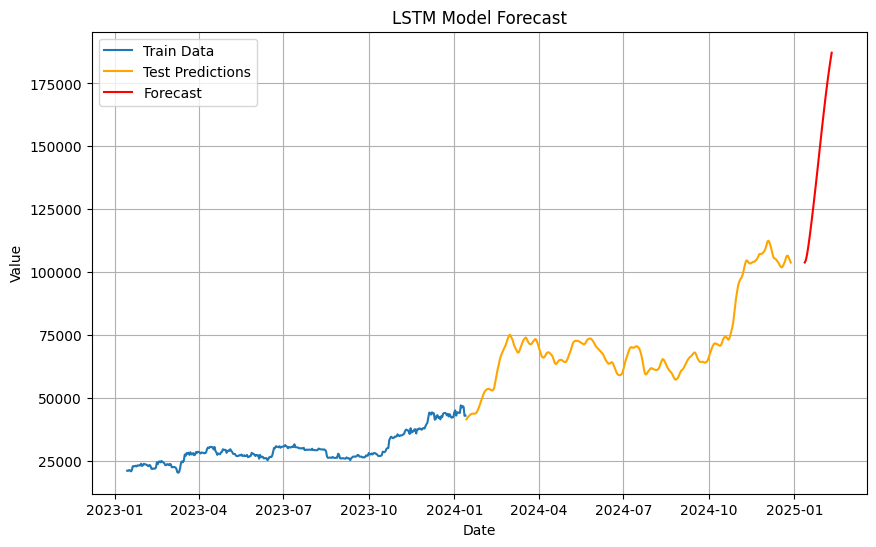

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime

class LSTMForecasting:
    def __init__(self, data: pd.DataFrame):
        """
        Initializes the LSTMForecasting class with the given data.

        Parameters:
        - data: pandas DataFrame containing the time series data with a 'y' column.
        """
        self.data = data
        self.train_data = None
        self.test_data = None
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = None

    def prepare_data(self, training_period: int = 730, look_back: int = 30):
        """
        Prepares the training and testing datasets for LSTM.

        Parameters:
        - training_period: Number of days to use for training. Default is 730 days.
        - look_back: Number of past days to use for prediction. Default is 30.
        """
        df.rename(columns={'Open Time': 'timestamp', 'Close': 'y'}, inplace=True)
        self.data['timestamp'] = pd.to_datetime(self.data['timestamp'], errors='coerce')
        self.data.set_index('timestamp', inplace=True)

        # Check if the dataset has sufficient rows
        if len(self.data) < (training_period + look_back):
            raise ValueError(
                f"Insufficient data for the specified training period ({training_period}) "
                f"and look-back window ({look_back}). Total rows: {len(self.data)}"
            )

        # Normalize the data
        normalized_data = self.scaler.fit_transform(self.data[['y']])

        # Split into training and testing data
        train_data = normalized_data[:training_period]
        test_data = normalized_data[training_period:]
        self.train_data = train_data
        self.test_data = test_data

        # Create datasets for LSTM
        def create_dataset(dataset, look_back):
            X, y = [], []
            for i in range(len(dataset) - look_back):
                X.append(dataset[i:(i + look_back), 0])
                y.append(dataset[i + look_back, 0])
            return np.array(X), np.array(y)

        X_train, y_train = create_dataset(train_data, look_back)
        X_test, y_test = create_dataset(test_data, look_back)

        # Reshape input to be [samples, time steps, features]
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        return X_train, y_train, X_test, y_test


    def build_model(self, input_shape):
        """
        Builds the LSTM model.

        Parameters:
        - input_shape: Shape of the input data for the LSTM model.
        """
        self.model = Sequential()
        self.model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
        self.model.add(LSTM(50))
        self.model.add(Dense(1))
        self.model.compile(optimizer='adam', loss='mean_squared_error')

    def train_model(self, X_train, y_train, epochs=50, batch_size=32):
        """
        Trains the LSTM model.

        Parameters:
        - X_train: Training input data.
        - y_train: Training output data.
        - epochs: Number of epochs for training. Default is 50.
        - batch_size: Batch size for training. Default is 32.
        """
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    def evaluate_model(self, X_test, y_test):
        """
        Evaluates the LSTM model on the test data.

        Parameters:
        - X_test: Test input data.
        - y_test: Test output data.

        Returns:
        - evaluation_metrics: Dictionary containing evaluation metrics (MSE, RMSE).
        """
        predictions = self.model.predict(X_test)
        predictions = self.scaler.inverse_transform(predictions)
        y_test = self.scaler.inverse_transform(y_test.reshape(-1, 1))

        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        evaluation_metrics = {'MSE': mse, 'RMSE': rmse}
        return evaluation_metrics, predictions

    def forecast(self, last_sequence, future_periods=180):
        """
        Forecast future values using the trained LSTM model.

        Parameters:
        - last_sequence: The last input sequence from the test data.
        - future_periods: Number of future periods to forecast.

        Returns:
        - forecast: Array of forecasted values.
        """
        forecast = []
        current_sequence = last_sequence.copy()

        for _ in range(future_periods):
            # Predict the next value
            next_value = self.model.predict(current_sequence)
            
            # Reshape next_value to match (1, 1, 1)
            next_value = next_value.reshape(1, 1, 1)
            
            # Update the current_sequence by appending the next_value
            current_sequence = np.append(current_sequence[:, 1:, :], next_value, axis=1)
            
            # Append the predicted value to the forecast
            forecast.append(next_value[0, 0, 0])

        # Reverse normalization
        forecast = self.scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
        return forecast


    def plot_forecast(self, predictions, forecast, look_back):
        """
        Plots the forecasted values along with the historical data.

        Parameters:
        - predictions: Predicted values for the test set.
        - forecast: Forecasted values for future periods.
        - look_back: Look-back period used for LSTM.
        """
        plt.figure(figsize=(10, 6))
        train_range = range(look_back, look_back + len(self.train_data))
        test_range = range(len(self.train_data) + look_back, len(self.train_data) + look_back + len(predictions))

        plt.plot(self.data.index[:len(self.train_data)], self.scaler.inverse_transform(self.train_data), label='Train Data')
        plt.plot(self.data.index[len(self.train_data):len(self.train_data) + len(predictions)], predictions, label='Test Predictions', color='orange')
        plt.plot(pd.date_range(self.data.index[-1], periods=len(forecast), freq='D'), forecast, label='Forecast', color='red')

        plt.title('LSTM Model Forecast')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()


# Example Usage:
if __name__ == "__main__":
    # Load your dataset (must include 'timestamp' and 'y' columns)
    df = pd.read_csv('/Users/mac/Desktop/Comapny2/CryptoPortfolioAI/Experiments/BTC_2Y_Binance.csv')

    # Initialize the LSTMForecasting class
    lstm_forecasting = LSTMForecasting(df)

    # Prepare the data
    X_train, y_train, X_test, y_test = lstm_forecasting.prepare_data(training_period=365, look_back=15)

    # Build the LSTM model
    lstm_forecasting.build_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    # Train the model
    lstm_forecasting.train_model(X_train, y_train, epochs=50, batch_size=32)

    # Evaluate the model
    evaluation_metrics, predictions = lstm_forecasting.evaluate_model(X_test, y_test)
    print(f"Model Evaluation: {evaluation_metrics}")

    # Forecast future values
    last_sequence = X_test[-1:]
    forecast = lstm_forecasting.forecast(last_sequence, future_periods=30)

    # Plot the results
    lstm_forecasting.plot_forecast(predictions, forecast, look_back=30)
